In [265]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import diffrax
from diffrax import diffeqsolve, Dopri5, ODETerm, SaveAt, PIDController
import equinox as eqx
import optax
from typing import Callable, List
import scipy
from tqdm.autonotebook import tqdm
from models.fno_model import FNO1d
from jax import random
from scipy.integrate import solve_ivp

## Adding noise to the training data

I now want to add noise to the absorption. This means I will add random Gaussian noise to every value a(r).

In [ ]:
# checken, wie man integriert, wenn Funktion nur an bestimmten Punkten bekannt 

# bzw checken, welche Punkte es zum integrieren nutzt, wahrscheinlich nicht nur die saveat Punkte

In [ ]:
# -> meine Implementierung hat jetzt im Prinzip constantes Noise in bestimmten Bereichen, fragen, ob das so okay ist

In [ ]:
# fragen , ob okay, dass Netz dann auch die noisy version von a(r) als Input bekommt oder ob es die nicht-noisy ersion als Input bekommen sollte

---------------------------

In [212]:
def rt_spherical_symmetry_ode(r, I, args):  
    noise = args[4]
    pre_a_value = args[0]*(r**args[1]) +  noise[jnp.argmin(jnp.abs(r_values - r))]
    a_value = jnp.maximum(pre_a_value, 0.0) # since I think negative values for a not reasonable
    j_value = args[2] #this value is used if r == r_min
    
    def case1(I):
        return -(a_value/2 + 1/r)*I +j_value/2
    def case2(I):
        return -(a_value/2 + 1/r)*I
    
    return jax.lax.cond(r == args[3], case1, case2, I)



def create_data_spherical_symmetry_variable_functions(
        r_min: jnp.ndarray, 
        r_max: jnp.ndarray, 
        I0: jnp.ndarray,
        K: jnp.ndarray,
        p: jnp.ndarray,
        j: jnp.ndarray):
    
    
    solver = Dopri5()
    stepsize_controller = PIDController(rtol=1e-5, atol=1e-5)
    term = ODETerm(rt_spherical_symmetry_ode)

    def solve_one(r0, r1, I_start, K, p, j, noise):
        r_values =  SaveAt(ts=jnp.linspace(r0, r1, 1000)) 
        sol = diffeqsolve(term, solver, t0=r0, t1=r1, dt0=None, y0=I_start,  
                          stepsize_controller=stepsize_controller, saveat=r_values, args=(K,p,j,r0, noise))   
        return sol.ts, sol.ys

    all_data = jnp.zeros((len(r_min), 3, 1000))
    noise = jax.random.normal(jax.random.PRNGKey(0), shape=(1000,1000))*10.0
    for i in range(len(all_data)):
        if i%100 == 0:
            print(f"{i}/1000")
        all_data =  all_data.at[i,0,:].set(solve_one(r_min[i], r_max[i], I0[i], K[i], p[i], j[i], noise[i])[0])
        all_data =  all_data.at[i,1,:].set(solve_one(r_min[i], r_max[i], I0[i], K[i], p[i], j[i], noise[i])[1])
        all_data =  all_data.at[i,2,:].set(noise[i])


    return all_data   






In [213]:
# arrays for different starting values -> keep in mind to not use r0 = 0
#r0s = jnp.array([1.0, 1.0, 1.0])
#r1s = jnp.array([10.0, 10.0, 10.0])
#I0s = jnp.array([1.0, 1.0, 1.0])
#Ks = jnp.array([1.0, 1.0, 1.0])
#ps = jnp.array([1.0, 1.0, 1.0])
#js = jnp.array([1.0, 1.0, 1.0])

###
r0s = jnp.ones(1000) * 0.1
r1s = jnp.ones(1000)
I0s = jnp.ones(1000)
Ks = jnp.ones(1000)

key = jax.random.PRNGKey(42)
key1, key2, key3 = jax.random.split(key, 3) 
Ks = jax.random.uniform(key1, shape=(1000,))
ps = jax.random.uniform(key2, shape=(1000,), minval=-2, maxval=-1)
js = jax.random.uniform(key3, shape=(1000,))
###




training_data = create_data_spherical_symmetry_variable_functions(r0s, r1s, I0s, Ks, ps, js)
training_data.shape

0/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000


(1000, 3, 1000)

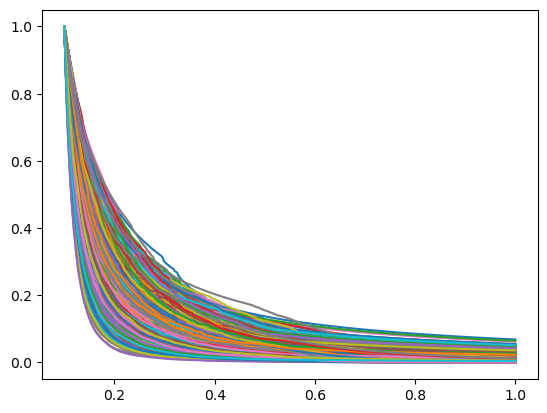

In [214]:
for i in range(1000):
    plt.plot(training_data[i,0,:], training_data[i,1,:])
#plt.ylim(0,3)
#plt.xlim(0,1)

In [215]:
r_shape_corrected = training_data[:,0,:][:,jnp.newaxis,:]

a_shape_corrected_prenoise = r_shape_corrected**ps[:, jnp.newaxis, jnp.newaxis] * Ks[:, jnp.newaxis, jnp.newaxis]
noise_shape_corrected = training_data[:,2,:][:,jnp.newaxis,:]
a_shape_corrected = jnp.maximum(a_shape_corrected_prenoise + noise_shape_corrected, 0.0)
j_shape_corrected = jnp.zeros_like(r_shape_corrected)
j_shape_corrected = j_shape_corrected.at[:, 0, 0].set(js)
input_function = jnp.concatenate((r_shape_corrected, a_shape_corrected, j_shape_corrected), axis=1)

I_shape_corrected = training_data[:,1,:][:,jnp.newaxis,:]

train_x, test_x = input_function[:800], input_function[800:1000] 
train_y, test_y = I_shape_corrected[:800], I_shape_corrected[800:1000]

In [225]:
# now data is used to train the model

In [260]:
fno = FNO1d(   # n blocks kann man auch noch modifizieren, ist standardmäßig 4
    3,
    1,
    62, #davor 16  # - solange nur jede 32 komponente von x genommen nur bis 17 modes möglich weil #modes = N//2 + 1 ( und N = 1000/32)
    128, #davor 64
    jax.nn.relu,
    key=jax.random.PRNGKey(0),
)

In [261]:
def dataloader(
    key,
    dataset_x,
    dataset_y,
    batch_size,
):
    n_samples = dataset_x.shape[0]

    n_batches = int(jnp.ceil(n_samples / batch_size))

    permutation = jax.random.permutation(key, n_samples)

    for batch_id in range(n_batches):
        start = batch_id * batch_size
        end = min((batch_id + 1) * batch_size, n_samples)

        batch_indices = permutation[start:end]

        yield dataset_x[batch_indices], dataset_y[batch_indices]

In [262]:
def loss_fn(model, x, y):
    y_pred = jax.vmap(model)(x)
    loss = jnp.mean(jnp.square(y_pred - y))
    return loss

optimizer = optax.adam(3e-4)
opt_state = optimizer.init(eqx.filter(fno, eqx.is_array))

@eqx.filter_jit   #was bedeutet das?
def make_step(model, state, x, y):
    loss, grad = eqx.filter_value_and_grad(loss_fn)(model, x, y)
    val_loss = loss_fn(model, test_x[..., ::8], test_y[..., ::8])  #ursprünglich 32 -> vllt auf 8 erhöhen
    updates, new_state = optimizer.update(grad, state, model)
    new_model = eqx.apply_updates(model, updates)
    return new_model, new_state, loss, val_loss

loss_history = []
val_loss_history = []

shuffle_key = jax.random.PRNGKey(10)
for epoch in tqdm(range(300)):
    shuffle_key, subkey = jax.random.split(shuffle_key)
    for (batch_x, batch_y) in dataloader(
        subkey,
        train_x[..., ::8],   #ursprünglich 32 -> vllt auf 8 erhöhen
        train_y[..., ::8],
        batch_size=100,
    ):
        fno, opt_state, loss, val_loss = make_step(fno, opt_state, batch_x, batch_y)
        loss_history.append(loss)
        val_loss_history.append(val_loss)

  0%|          | 0/300 [00:00<?, ?it/s]

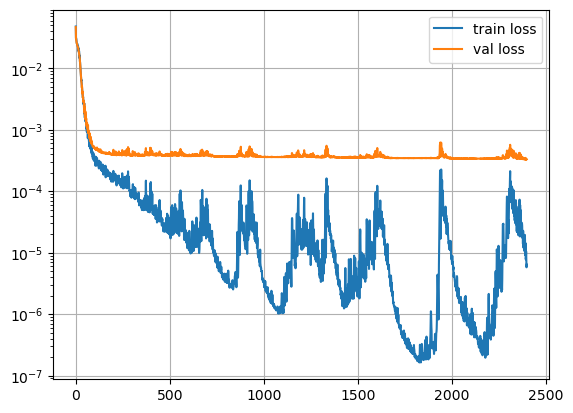

In [263]:
plt.plot(loss_history, label="train loss")
plt.plot(val_loss_history, label="val loss")
plt.legend()
plt.yscale("log")
plt.grid()

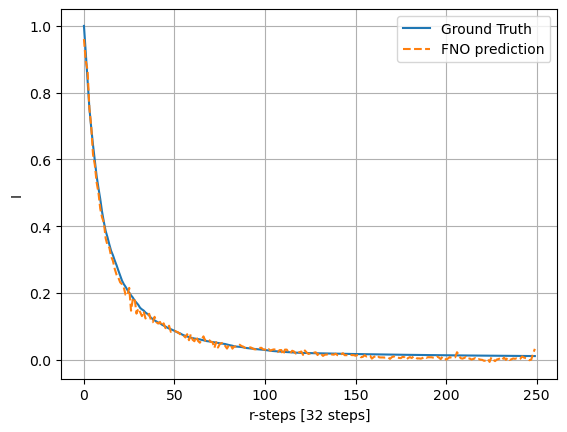

In [264]:
plt.plot(test_y[1, 0, ::4], label="Ground Truth")
plt.plot(fno(test_x[1, :, ::4])[0], label="FNO prediction", linestyle='--')
plt.legend()
plt.xlabel('r-steps [32 steps]')
plt.ylabel('I')
plt.grid()

In [ ]:
# oder sollte ein constantes noise auf alle a(r) von einem training example?

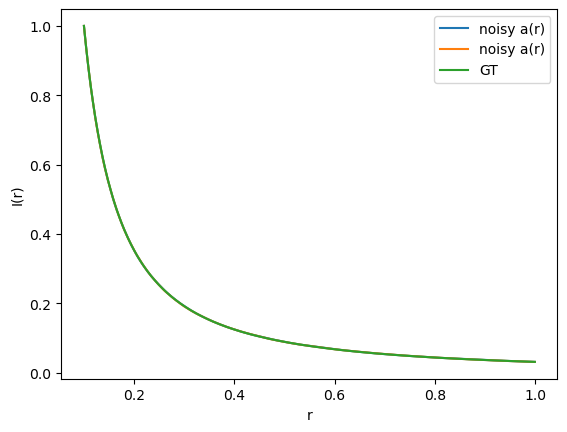

In [405]:
#trying out Runge Kutta with a fixed "grid" for the ODE

r_min, r_max, N = 0.1, 1.0, 2000 
r_lin = jnp.linspace(r_min, r_max, N)
dr = r_lin[1] - r_lin[0]  # Schrittweite
key = random.PRNGKey(0) 
no_noise = jnp.zeros(1000)
noises = random.normal(key, (2, 2000)) 

K = 1
p = -1
j = 1


def f(r, I, args):
    a = jnp.maximum(args[0]*(r**args[1]) + args[3][int(r//dr - r_lin[0]//dr)], 0) # a below 0 is not possible
    j = args[2] #this value is used if r == r_min
    if r == r_lin[0]:
        return -(a/2 + 1/r)*I +j/2
    else:
        return -(a/2 + 1/r)*I

#basic definition of a Runge Kutta step - added K,p,j
def rk4_step(I, r, dr, K, p, j, noise):
    k1 = f(r, I, (K, p, j, noise))
    k2 = f(r + dr / 2, I + dr / 2 * k1, (K, p, j, noise))
    k3 = f(r + dr / 2, I + dr / 2 * k2, (K, p, j, noise))
    k4 = f(r + dr, I + dr * k3, (K, p, j, noise))
    
    return I + (dr / 6) * (k1 + 2*k2 + 2*k3 + k4)

I = jnp.zeros(1000)
I = I.at[0].set(1.)  

for j in range(len(noises)):
    for i in range(int(N/2 - 1)):
        I = I.at[i + 1].set(rk4_step(I[i], r_lin[2*i], 2*dr, K, p, j, noises[j]))
    plt.plot(r_lin[::2], I, label = "noisy a(r)")

for i in range(int(N/2 - 1)):
    I = I.at[i + 1].set(rk4_step(I[i], r_lin[2*i], 2*dr, K, p, j, no_noise))
plt.plot(r_lin[::2], I, label = "GT")



plt.legend()
plt.xlabel("r")
plt.ylabel("I(r)")
plt.show()


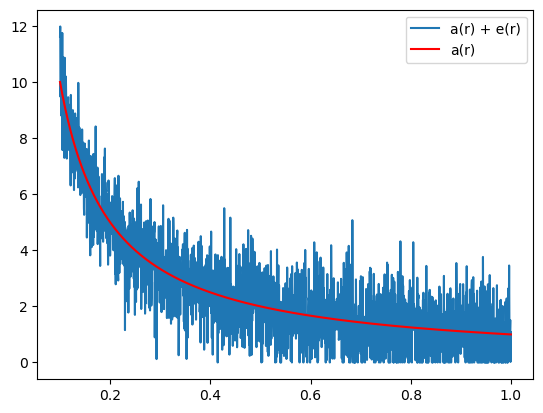

In [406]:
plt.plot(r_lin, jnp.maximum(K * r_lin** p + noises[0],0), label = "a(r) + e(r)")
plt.plot(r_lin, K * r_lin** p, color= "red", label = "a(r)")
plt.legend()
plt.show()

In [ ]:
# vllt noch Ansatz aus Dullemond Skript überprüfen

In [ ]:
# alternativ a(r) + e(r) auf grid erzeugen (wie auch hier) dann Interpolation und dann halt solve_ivp oder etwas aus diffrax 

In [407]:
# script to generatre noise - I

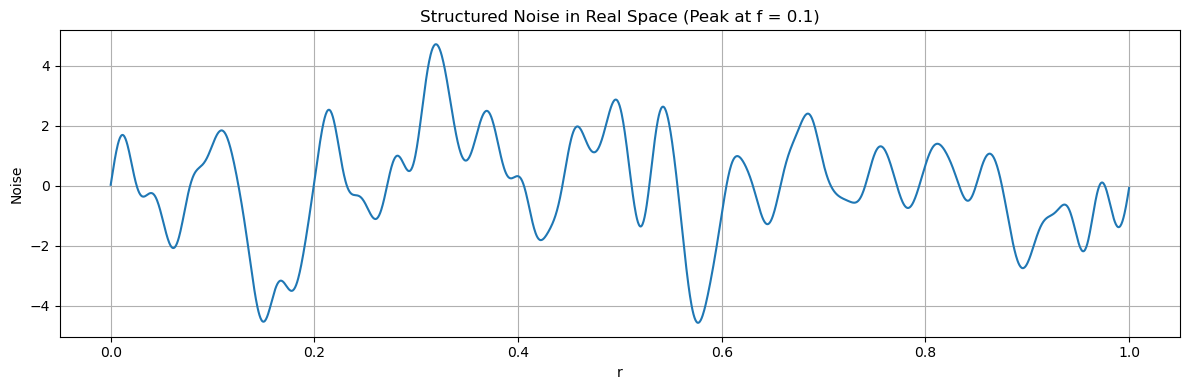

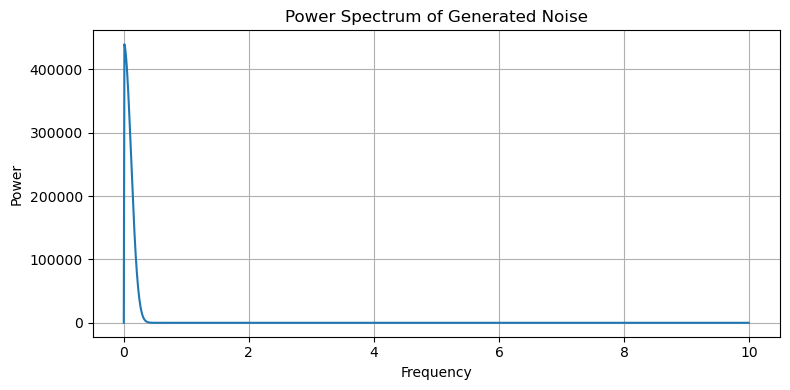

In [518]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
N = 2000 # davor 1024          # Number of points
L = 1.0            # Domain length
r = np.linspace(0, L, N)

amplitude = 1e2 #very Important!

# Frequencies: cycles per unit length
k = np.fft.fftfreq(N, d=amplitude*L/N) 

# Desired frequency peak and spread
f0 = 0.05           # Peak frequency in 1/m
sigma = 0.1       # Spread in frequency


# Build power spectrum: symmetric Gaussian around ±f0
P = np.exp(-0.5 * ((k - f0) / sigma)**2) + np.exp(-0.5 * ((k + f0) / sigma)**2)

# Random phases only for positive frequencies
random_phases = np.exp(2j * np.pi * np.random.rand(N))

# Fourier coefficients: amplitude * phase
fourier_noise = np.sqrt(P) * random_phases

# Hermitian symmetry (for real IFFT)
# Set DC and Nyquist real
fourier_noise[0] = 0  # optional: zero mean
fourier_noise[N//2] = fourier_noise[N//2].real

# Mirror positive frequencies to negative frequencies
for i in range(1, N//2):
    fourier_noise[-i] = np.conj(fourier_noise[i])

# Inverse FFT to real space
noise = np.fft.ifft(fourier_noise).real * 500

# Plot noise
plt.figure(figsize=(12, 4))
plt.plot(r, noise)
plt.title("Structured Noise in Real Space (Peak at f = 0.1)")
plt.xlabel("r")
plt.ylabel("Noise")
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Plot power spectrum
P_noise = np.abs(np.fft.fft(noise))**2
plt.figure(figsize=(8, 4))
plt.plot(k[:N//2], P_noise[:N//2])
plt.title("Power Spectrum of Generated Noise")
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.grid(True)
plt.tight_layout()
plt.show()

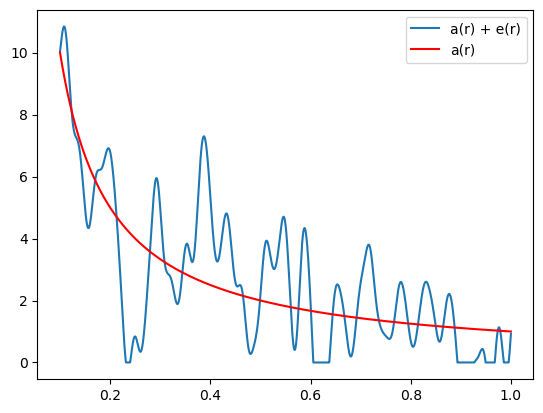

In [519]:
plt.plot(r_lin, jnp.maximum(K * r_lin** p + noise,0), label = "a(r) + e(r)")
plt.plot(r_lin, K * r_lin** p, color= "red", label = "a(r)")
plt.legend()
plt.show()

[-2.13398384 -2.09400729 -2.05376121 ... -2.2521549  -2.21307178
 -2.17367671]
[10.         9.955179   9.910759  ...  1.0009012  1.0004504  1.       ]
0.1
7.8660164
10.0
-2.133983835371772
-------------
0.100450225
7.8611717
9.955179
-2.0940072887820795
-------------
0.100450225
7.8611717
9.955179
-2.0940072887820795
-------------
0.10090045
7.8569975
9.910759
-2.0537612057247476
-------------
0.10090045
7.8569975
9.910759
-2.0537612057247476
-------------
0.10135067
7.8534727
9.866733
-2.013259706390383
-------------
0.10135067
7.8534727
9.866733
-2.013259706390383
-------------
0.101800896
7.8505793
9.823096
-1.9725168937961617
-------------
0.1018009
7.8505783
9.823095
-1.9725168937961617
-------------
0.10225113
7.8482966
9.779843
-1.9315468489052556
-------------
0.10225113
7.8482966
9.779843
-1.9315468489052556
-------------
0.10270135
7.8466063
9.73697
-1.890363625787152
-------------
0.10270135
7.8466063
9.73697
-1.890363625787152
-------------
0.103151575
7.84549
9.694471
-1.8

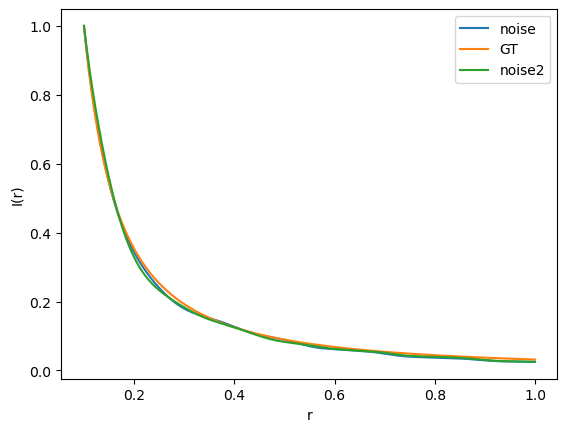

In [515]:
#now try how I(r) looks with this noise

r_min, r_max, N = 0.1, 1.0, 2000 
r_lin = jnp.linspace(r_min, r_max, N)
dr = r_lin[1] - r_lin[0]  # Schrittweite

no_noise = jnp.zeros(1000)
#key = random.PRNGKey(0) 
#noises = random.normal(key, (2, 2000)) 

K = 1
p = -1
j = 1

a = 

def f(r, I, args):
    #a = args[0]*(r**args[1]) + args[3][int(r//dr - r_lin[0]//dr)]
    a = jnp.maximum(args[0]*(r**args[1]) + args[3][int(r//dr - r_lin[0]//dr)], 0) # a below 0 is not possible
    print(args[3][int(r//dr - r_lin[0]//dr)])
    print("-------------")
    j = args[2] #this value is used if r == r_min
    if r == r_lin[0]:
        return -(a/2 + 1/r)*I +j/2
    else:
        return -(a/2 + 1/r)*I

#basic definition of a Runge Kutta step - added K,p,j
def rk4_step(I, r, dr, K, p, j, noise):
    k1 = f(r, I, (K, p, j, noise))
    k2 = f(r + dr / 2, I + dr / 2 * k1, (K, p, j, noise))
    k3 = f(r + dr / 2, I + dr / 2 * k2, (K, p, j, noise))
    k4 = f(r + dr, I + dr * k3, (K, p, j, noise))
    
    return I + (dr / 6) * (k1 + 2*k2 + 2*k3 + k4)

I = jnp.zeros(1000)
I = I.at[0].set(1.)  

#for j in range(len(noise)):
#    for i in range(int(N/2 - 1)):
#        I = I.at[i + 1].set(rk4_step(I[i], r_lin[2*i], 2*dr, K, p, j, noise[j]))
#    plt.plot(r_lin[::2], I, label = "noisy a(r)")

for i in range(int(N/2 - 1)):
    I = I.at[i + 1].set(rk4_step(I[i], r_lin[2*i], 2*dr, K, p, j, noise))
plt.plot(r_lin[::2], I, label = "noise")

for i in range(int(N/2 - 1)):
    I = I.at[i + 1].set(rk4_step(I[i], r_lin[2*i], 2*dr, K, p, j, no_noise))
plt.plot(r_lin[::2], I, label = "GT")

for i in range(int(N/2 - 1)):
    I = I.at[i + 1].set(rk4_step(I[i], r_lin[2*i], 2*dr, K, p, j, noise2))
plt.plot(r_lin[::2], I, label = "noise2")



plt.legend()
plt.xlabel("r")
plt.ylabel("I(r)")
plt.show()


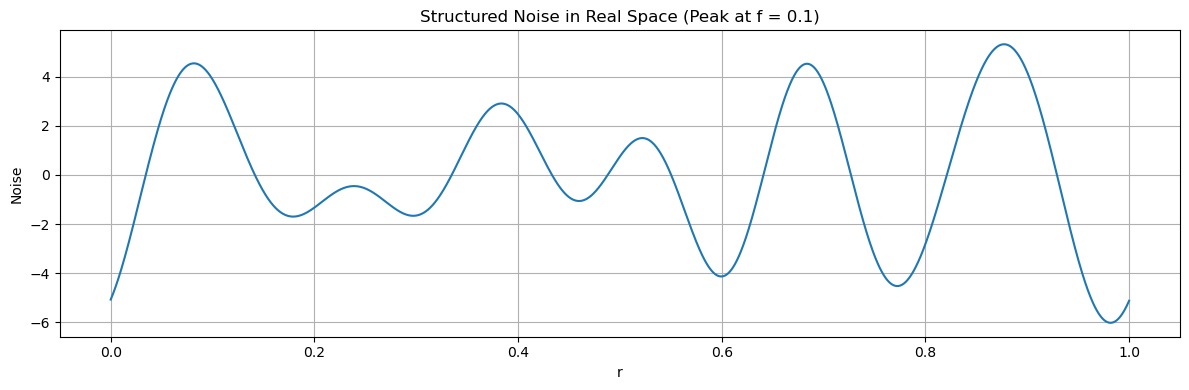

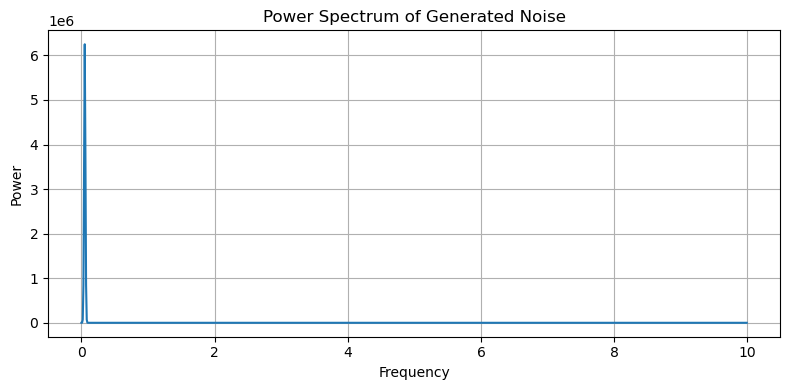

In [514]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
N = 2000 # davor 1024          # Number of points
L = 1.0            # Domain length
r = np.linspace(0, L, N)

amplitude = 1e2 #very Important!

# Frequencies: cycles per unit length
k = np.fft.fftfreq(N, d=amplitude*L/N) 

# Desired frequency peak and spread
f0 = 0.05           # Peak frequency in 1/m
sigma = 0.01       # Spread in frequency


# Build power spectrum: symmetric Gaussian around ±f0
P = np.exp(-0.5 * ((k - f0) / sigma)**2) + np.exp(-0.5 * ((k + f0) / sigma)**2)

# Random phases only for positive frequencies
random_phases = np.exp(2j * np.pi * np.random.rand(N))

# Fourier coefficients: amplitude * phase
fourier_noise = np.sqrt(P) * random_phases

# Hermitian symmetry (for real IFFT)
# Set DC and Nyquist real
fourier_noise[0] = 0  # optional: zero mean
fourier_noise[N//2] = fourier_noise[N//2].real

# Mirror positive frequencies to negative frequencies
for i in range(1, N//2):
    fourier_noise[-i] = np.conj(fourier_noise[i])

# Inverse FFT to real space
noise2 = np.fft.ifft(fourier_noise).real * 2500

# Plot noise
plt.figure(figsize=(12, 4))
plt.plot(r, noise2)
plt.title("Structured Noise in Real Space (Peak at f = 0.1)")
plt.xlabel("r")
plt.ylabel("Noise")
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Plot power spectrum
P_noise = np.abs(np.fft.fft(noise))**2
plt.figure(figsize=(8, 4))
plt.plot(k[:N//2], P_noise[:N//2])
plt.title("Power Spectrum of Generated Noise")
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.grid(True)
plt.tight_layout()
plt.show()

--------------------------------------

In [ ]:
# umschreiben, s.d. a und j als arrays input sind

# evtl so umschreiben, dass noise relativ applied wird (also s.d. Amplitude zwischen 0 und 1 in etwa (gucken wie das geht) und dann mal 0.2 von a vllt)

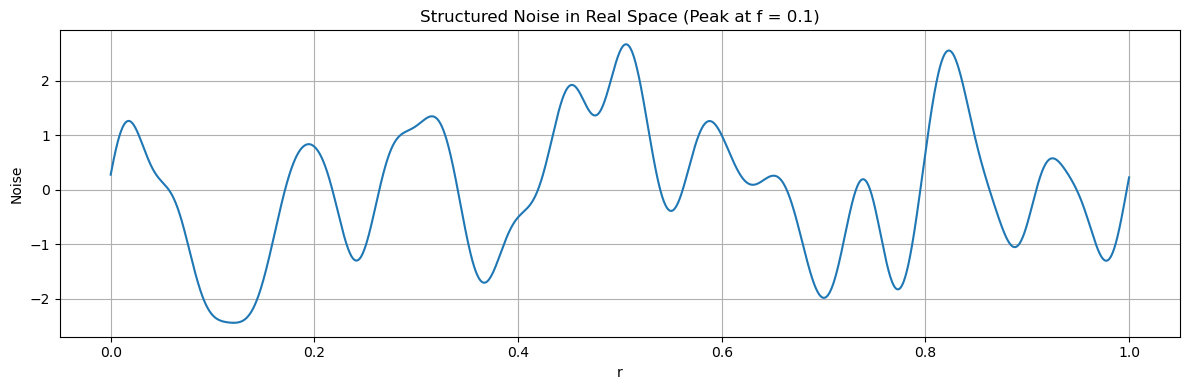

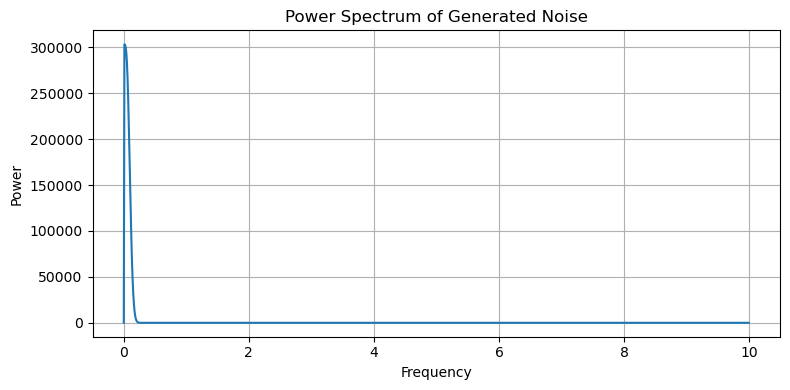

In [553]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
N = 2000 # davor 1024          # Number of points
L = 1.0            # Domain length
r = np.linspace(0, L, N)

amplitude = 1e2 #very Important!

# Frequencies: cycles per unit length
k = np.fft.fftfreq(N, d=amplitude*L/N) 

# Desired frequency peak and spread
f0 = 0.05           # Peak frequency in 1/m
sigma = 0.05       # Spread in frequency


# Build power spectrum: symmetric Gaussian around ±f0
P = np.exp(-0.5 * ((k - f0) / sigma)**2) + np.exp(-0.5 * ((k + f0) / sigma)**2)

# Random phases only for positive frequencies
random_phases = np.exp(2j * np.pi * np.random.rand(N))

# Fourier coefficients: amplitude * phase
fourier_noise = np.sqrt(P) * random_phases

# Hermitian symmetry (for real IFFT)
# Set DC and Nyquist real
fourier_noise[0] = 0  # optional: zero mean
fourier_noise[N//2] = fourier_noise[N//2].real

# Mirror positive frequencies to negative frequencies
for i in range(1, N//2):
    fourier_noise[-i] = np.conj(fourier_noise[i])

# Inverse FFT to real space
noise = np.fft.ifft(fourier_noise).real * 500

# Plot noise
plt.figure(figsize=(12, 4))
plt.plot(r, noise)
plt.title("Structured Noise in Real Space (Peak at f = 0.1)")
plt.xlabel("r")
plt.ylabel("Noise")
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Plot power spectrum
P_noise = np.abs(np.fft.fft(noise))**2
plt.figure(figsize=(8, 4))
plt.plot(k[:N//2], P_noise[:N//2])
plt.title("Power Spectrum of Generated Noise")
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.grid(True)
plt.tight_layout()
plt.show()

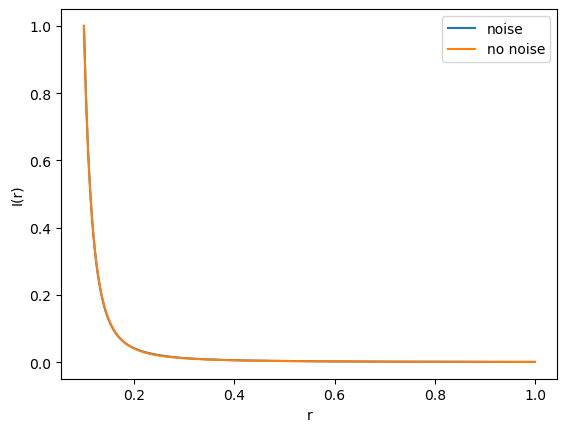

In [556]:
#now try how I(r) looks with this noise

r_min, r_max, N = 0.1, 1.0, 2000 
r_lin = jnp.linspace(r_min, r_max, N)
dr = r_lin[1] - r_lin[0]  # Schrittweite

no_noise = jnp.zeros(1000)
#key = random.PRNGKey(0) 
#noises = random.normal(key, (2, 2000)) 

K = 1
p = -1
j_start = 1

a = K * r_lin**p + noise
j = np.zeros_like(a)
j[0] = j_start
a_no_noise = K * r_lin**p




def f(r, I, args):
    #a = args[0]*(r**args[1]) + args[3][int(r//dr - r_lin[0]//dr)]
    a = jnp.maximum(args[0][int(r//dr - r_lin[0]//dr)], 0) # a below 0 is not possible
    j = jnp.maximum(args[1][int(r//dr - r_lin[0]//dr)], 0)
    if r == r_lin[0]:
        return -(a/2 + 1/r)*I +j/2
    else:
        return -(a/2 + 1/r)*I

#basic definition of a Runge Kutta step - added K,p,j
def rk4_step(I, r, dr, a, j):
    k1 = f(r, I, (a, j))
    k2 = f(r + dr / 2, I + dr / 2 * k1, (a, j))
    k3 = f(r + dr / 2, I + dr / 2 * k2, (a, j))
    k4 = f(r + dr, I + dr * k3, (a, j))
    
    return I + (dr / 6) * (k1 + 2*k2 + 2*k3 + k4)

I = jnp.zeros(1000)
I = I.at[0].set(1.)  

#for j in range(len(noise)):
#    for i in range(int(N/2 - 1)):
#        I = I.at[i + 1].set(rk4_step(I[i], r_lin[2*i], 2*dr, K, p, j, noise[j]))
#    plt.plot(r_lin[::2], I, label = "noisy a(r)")





for i in range(int(N/2 - 1)):
    I = I.at[i + 1].set(rk4_step(I[i], r_lin[2*i], 2*dr, a, j))
plt.plot(r_lin[::2], I, label = "noise")

for i in range(int(N/2 - 1)):
    I = I.at[i + 1].set(rk4_step(I[i], r_lin[2*i], 2*dr, a_no_noise, j))

plt.plot(r_lin[::2], I, label = "no noise")
plt.legend()
plt.xlabel("r")
plt.ylabel("I(r)")
plt.show()


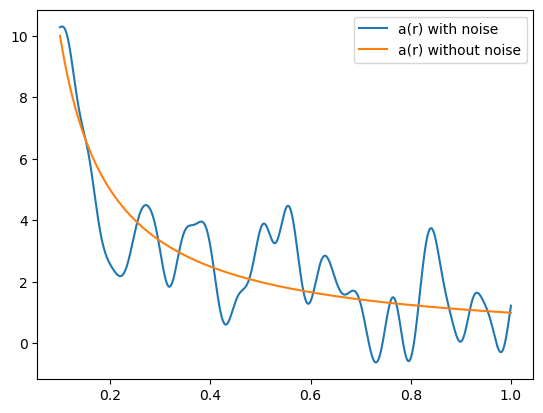

In [555]:
plt.plot(r_lin, a, label="a(r) with noise")
plt.plot(r_lin, a_no_noise, label="a(r) without noise")
#plt.plot(r_lin, noise)
plt.legend()
plt.show()

In [ ]:
# passt denke ich jetzt -> wenn ich das in eine proper Methode umsetze vllt auch (ggf in algernativer Form) mit interpolate und ivp solve